In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
from keras.layers import Conv2D, BatchNormalization, Input, GlobalAveragePooling2D, Dense
from keras.models import Model
from keras.layers import LeakyReLU
import random

In [2]:
import cv2
from PIL import Image as im

In [3]:
from keras.layers import Conv2DTranspose, Reshape
import pandas as pd
import os
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from IPython.display import clear_output
from keras.models import Sequential

In [4]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from IPython.display import clear_output

In [5]:
def build_discriminator(start_filters,spatial_dim,filter_size):
    
    
    def discriminator(model1,filters,filter_size):
        
        model1 = Conv2D(filters, filter_size, padding='same')(model1)
        model1 = BatchNormalization()(model1)
        model1 = Conv2D(filters, filter_size, padding='same', strides=2)(model1)
        model1 = BatchNormalization()(model1)
        model1 = LeakyReLU(0.3)(model1)
        return model1
        return model1
    inp = Input(shape=(spatial_dim, spatial_dim, 3))
    model1 = discriminator(inp, start_filters, filter_size)
    model1 = discriminator(model1, start_filters * 2, filter_size)
    model1 = discriminator(model1, start_filters * 4, filter_size)
    model1 = discriminator(model1, start_filters * 8, filter_size)
    
    
    model1 = GlobalAveragePooling2D()(model1)
    model1 = Dense(1, activation='sigmoid')(model1)
    
    return Model(inputs=inp, outputs=model1)
    

In [6]:
def build_generator(start_filters, filter_size, latent_dim):
    
    def generator(model,filters,filter_size):
        model = Conv2DTranspose(filters, filter_size, strides=2, padding='same')(model)
        model = BatchNormalization()(model)
        model = LeakyReLU(0.3)(model)
        return model
    
    inp = Input(shape=(latent_dim,))
    
    model = Dense(4 * 4 * (start_filters * 8), input_dim=latent_dim)(inp)
    model = BatchNormalization()(model)
    model = Reshape(target_shape=(4, 4, start_filters * 8))(model)
    
    model = generator(model, start_filters * 4, filter_size)
    model = generator(model, start_filters * 2, filter_size)
    model = generator(model, start_filters, filter_size)
    model = generator(model, start_filters, filter_size)   
    
    model = Conv2D(3, kernel_size=8, padding='same', activation='tanh')(model)
    return Model(inputs=inp, outputs=model)

In [7]:
df_celeb = pd.read_csv('/kaggle/input/celeba-dataset/list_attr_celeba.csv')
TOTAL_SAMPLES = df_celeb.shape[0]

# we will downscale the images
SPATIAL_DIM = 64 
# size of noise vector
LATENT_DIM_GAN = 100 
# filter size in conv layer
FILTER_SIZE = 5
# number of filters in conv layer
NET_CAPACITY = 16
# batch size
BATCH_SIZE_GAN = 32
# interval for displaying generated images
PROGRESS_INTERVAL = 80 
# directory for storing generated images
ROOT_DIR = 'visualization2'
if not os.path.isdir(ROOT_DIR):
    os.mkdir(ROOT_DIR)
def construct_models(verbose=False):
    discriminator = build_discriminator(NET_CAPACITY, SPATIAL_DIM, FILTER_SIZE)
    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002), metrics=['mae'])
    
    generator = build_generator(NET_CAPACITY, FILTER_SIZE, LATENT_DIM_GAN)
    
    
    gan = Sequential()
    gan.add(generator)
    gan.add(discriminator)
    discriminator.trainable = False 
    gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002), metrics=['mae'])
    
    if verbose: 
        generator.summary()
        discriminator.summary()
        gan.summary()
        
    return generator, discriminator, gan
  
generator_celeb, discriminator_celeb, gan_celeb = construct_models(verbose=True)
    

2023-01-11 08:29:24.318837: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-11 08:29:24.410720: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-11 08:29:24.411532: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-11 08:29:24.412683: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              206848    
_________________________________________________________________
batch_normalization_8 (Batch (None, 2048)              8192      
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 64)          204864    
_________________________________________________________________
batch_normalization_9 (Batch (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 64)          0   

<Figure size 360x144 with 0 Axes>

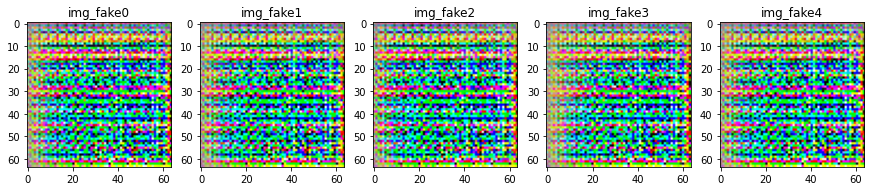

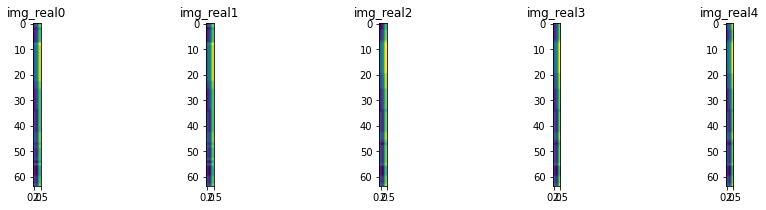

<Figure size 360x144 with 0 Axes>

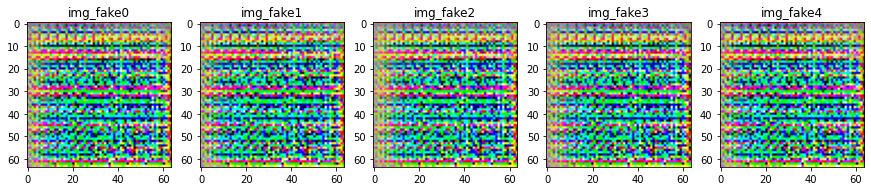

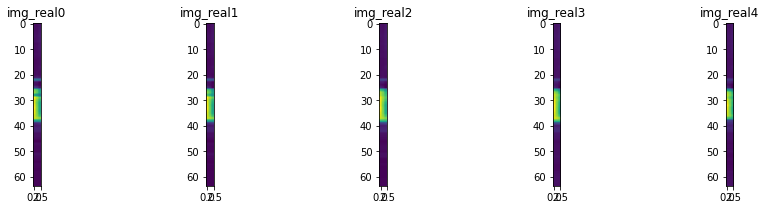

In [ ]:
DISC_UPDATES = 1  
# number of generator updates per alternating training iteration
GEN_UPDATES = 1 

def run_training(generator, discriminator, gan, df=df_celeb, start_it=0, num_epochs=1000):
    
    
      # helper function for selecting 'size' real images
      # and downscaling them to lower dimension SPATIAL_DIM
    def get_real_images(df, size, total):
        cur_files = df.sample(frac=1).iloc[0:size]
        X = np.empty(shape=(size, SPATIAL_DIM, SPATIAL_DIM, 3))
        for i in range(0, size):
            file = cur_files.iloc[i]
            img_uri = '/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/' + file.image_id
            img = cv2.imread(img_uri)
            img = cv2.resize(img, (SPATIAL_DIM, SPATIAL_DIM))
            img = np.flip(img, axis=2)
            img = img.astype(np.float32) / 127.5 - 1.0
            X[i] = img
        return X
    
    avg_loss_discriminator = []
    avg_loss_generator = []
    total_it = start_it

  # main training loop
    for epoch in range(num_epochs):

      # alternating training loop
        loss_discriminator = []
        loss_generator = []
        for it in range(200):
            

          #### Discriminator training loop ####
            for i in range(DISC_UPDATES): 
              # select a random set of real images
              imgs_real = get_real_images(df, BATCH_SIZE_GAN, TOTAL_SAMPLES)
              # generate a set of random noise vectors
              noise = np.random.randn(BATCH_SIZE_GAN, LATENT_DIM_GAN)
              # generate a set of fake images using the generator
              imgs_fake = generator.predict(noise)
              
              
              # train the discriminator on real images with label 1
              d_loss_real = discriminator.train_on_batch(imgs_real, np.ones([BATCH_SIZE_GAN]))[1]
              # train the discriminator on fake images with label 0
              d_loss_fake = discriminator.train_on_batch(imgs_fake, np.zeros([BATCH_SIZE_GAN]))[1]
                
            if total_it % PROGRESS_INTERVAL == 0:
                plt.figure(figsize=(5,2))
                num_vis = min(BATCH_SIZE_GAN, 5)
                imgs_real = get_real_images(df, num_vis, TOTAL_SAMPLES)[0]
                noise = np.random.randn(num_vis, LATENT_DIM_GAN)
                imgs_fake = generator.predict(noise)
                for obj_plot in [imgs_fake, imgs_real]:
                    plt.figure(figsize=(num_vis * 3, 3))
                    for b in range(num_vis):
#                         disc_score = float(discriminator.predict(np.expand_dims(obj_plot[b], axis=0))[0])
                        if obj_plot is imgs_fake:
                            plt.subplot(1, num_vis, b + 1)
                            plt.title(str("img_fake"+str(b)))
                            plt.imshow(obj_plot[b] * 0.5 + 0.5)
                        else:
                            plt.subplot(1, num_vis, b + 1)
                            plt.title(str("img_real"+str(b)))
                            plt.imshow(obj_plot[b] * 0.5 + 0.5)
#                         plt.subplot(1, num_vis, b + 1)
#                         plt.title(str(round(disc_score, 3)))
#                         
#                         plt.imshow(obj_plot[b] * 0.5 + 0.5) 
                    if obj_plot is imgs_fake:
                        plt.savefig(os.path.join(ROOT_DIR, str(total_it).zfill(10) + '.jpg'), format='jpg', bbox_inches='tight')
                    plt.show() 
                    
            loss = 0
            y = np.ones([BATCH_SIZE_GAN, 1]) 
            for j in range(GEN_UPDATES):
              # generate a set of random noise vectors
                noise = np.random.randn(BATCH_SIZE_GAN, LATENT_DIM_GAN)
              # train the generator on fake images with label 1
                loss += gan.train_on_batch(noise, y)[1]
                loss = 0
            y = np.ones([BATCH_SIZE_GAN, 1]) 
            for j in range(GEN_UPDATES):
              # generate a set of random noise vectors
                noise = np.random.randn(BATCH_SIZE_GAN, LATENT_DIM_GAN)
              # train the generator on fake images with label 1
                loss += gan.train_on_batch(noise, y)[1]  
             
            loss_discriminator.append((d_loss_real + d_loss_fake) / 2.)        
            loss_generator.append(loss / GEN_UPDATES)
            total_it += 1
            
        clear_output(True)
        print('Epoch', epoch)
        avg_loss_discriminator.append(np.mean(loss_discriminator))
        avg_loss_generator.append(np.mean(loss_generator))
        plt.plot(range(len(avg_loss_discriminator)), avg_loss_discriminator)
        plt.plot(range(len(avg_loss_generator)), avg_loss_generator)
        plt.legend(['discriminator loss', 'generator loss'])
        plt.show()
    return generator, discriminator, gan
generator_celeb, discriminator_celeb, gan_celeb = run_training(generator_celeb, 
                                                               discriminator_celeb, 
                                                               gan_celeb, 
                                                               num_epochs=500, 
                                                               df=df_celeb)


                
                
                
            